First, we add all the necessary packages and define some useful functions.

In [2]:
using Flux, OneHotArrays, Random, Statistics, CairoMakie, Distributions, CUDA

function variation(vec::Vector)
    findmax(abs.(vec[2:end]-vec[1:end-1]))[1]
end

function histogram_forward(model::Chain, layers, X; bins=100)
    fig=Figure()
    ax=Axis(fig[1,1])
    for layer in layers
        hist!(ax,(model[1:layer](X))[:], label="after layer: $layer",bins=bins, normalization=:probability)
    end
    Legend(fig[1,2],ax)
    return fig
end

function histogram_forward(model::Chain, layers, X, neurons; bins=100)
    fig=Figure()
    ax=Axis(fig[1,1])
    for layer in layers
        for nr in neurons
            hist!(ax,(model[1:layer](X))[nr,:], label="after layer: $layer, at neuron: $nr",bins=bins, normalization=:probability)
        end
    end
    Legend(fig[1,2],ax)
    return fig
end

histogram_forward (generic function with 2 methods)

We read out the names file and create char::Array, char_to_index::Dict, index_to_char::Dict. We also define here the function `build_dataset`, that takes a word list and creates a dataset as explained in the following cell. 

In [3]:
file=open("names.txt")
const words=collect(Set(readlines(file)))
close(file)
file=nothing

const chars=Set(join(push!(words,"."))) |> collect |> sort
const char_to_index=Dict(enumerate(chars) .|> x->(x[2],x[1]));
const index_to_char=Dict(enumerate(chars) .|> x-> (x[1],x[2])); 

function build_dataset(words; context_window_size=3)
    cyclic_permutation=push!(collect(2:context_window_size),1)
    dataset_size=(words .|> length |> sum)+length(words) # for each char in words we can create an example + for each end of the word (the number of ends of words = number of words)
    X=zeros(Int32,context_window_size,dataset_size)
    Y=zeros(Int32,dataset_size)
    cnt=0
    for w in words
        context=ones(Int32,context_window_size)
        for ch in w*"."
            cnt+=1
            index=char_to_index[ch]
            X[:,cnt].=context
            Y[cnt]=index
            context=context[cyclic_permutation]
            context[end]=index
        end
    end
    Y=onehotbatch(Y,1:length(chars)) 
    return X,Y
end

build_dataset (generic function with 1 method)

Let us collect some statistics about the words set.

length of the words list: 29495
mean length of a word: 6.16494321071368
standard deviation of length of a word: 1.4375939331170051


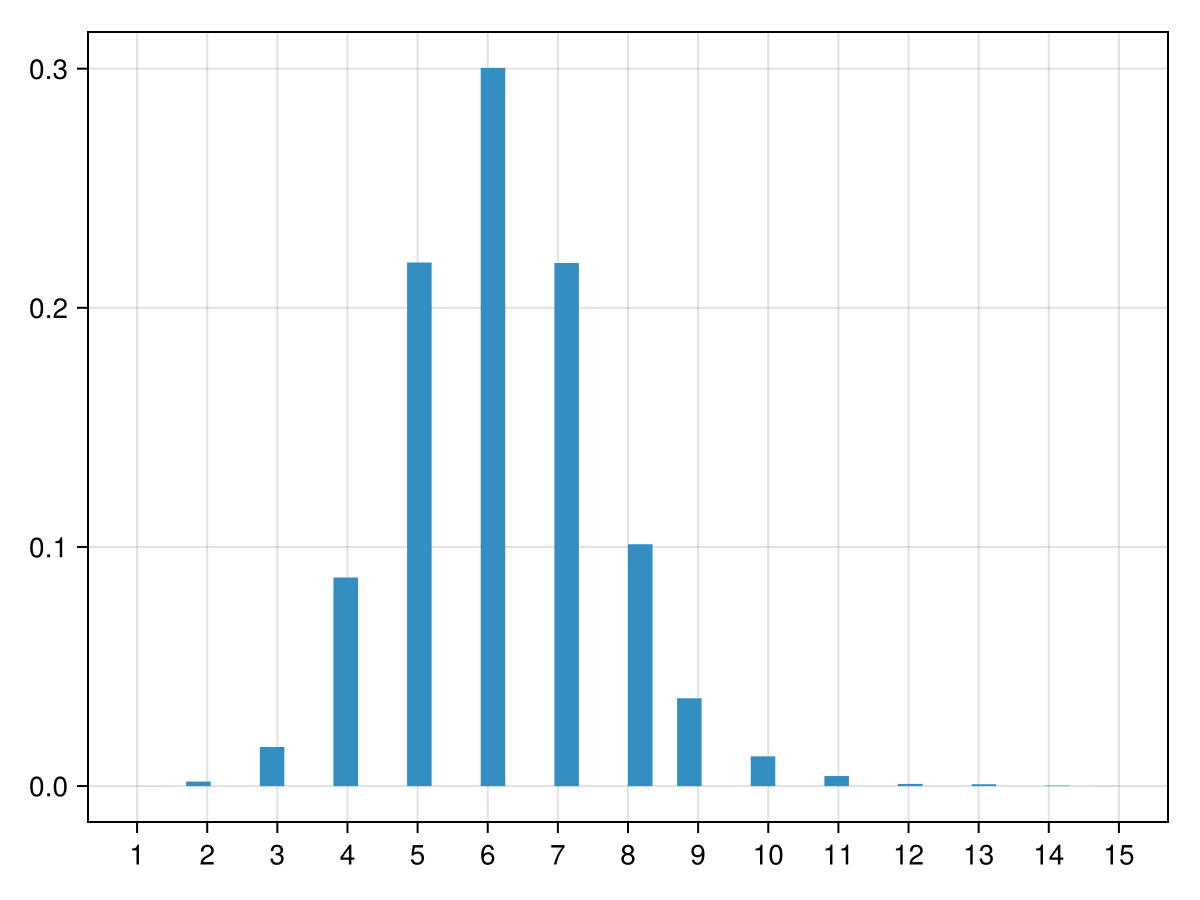

In [4]:
println("length of the words list: ",length(words))
println("mean length of a word: ",mean(words .|> length))
println("standard deviation of length of a word: ",sqrt(var(words .|> length)))
fig=Figure()
ax=Axis(
    fig[1,1],
    xticks=1:15
)
hist!(ax,words.|>length;bins=40,normalization=:probability)
fig

The histogram suggests that the `context_window_size=10` should be a good choice as it covers all most probable name lengths.

We choose the context_window_size below and build three datasets. One dataset consists of matrix `X` of size `context_window_size`*`dataset size` filled with integers. Each column of `X` represents a sequence of `context_window_size` chars encoded via `char_to_index` dictionary. The i-th vector element of `Y` encodes a char that follows the corresponding `context_window_size` chars in `X[:,i]`.    

In [7]:
const context_window_size=10

shuffle!(words);
n1=floor(0.8*length(words)) |> Int32;
n2=floor(0.9*length(words)) |> Int32;

Xtr,Ytr=build_dataset(words[1:n1];context_window_size=context_window_size);
Xtst,Ytst=build_dataset(words[n1+1:n2];context_window_size=context_window_size);
Xdev,Ydev=build_dataset(words[n2+1:end];context_window_size=context_window_size);

Let us check that the datasets are created correctly. This cell should print words and all the examples we extracted from the word.

In [8]:
X_tmp=Xtr
Y_tmp=onecold(Ytr)
for i =1:100
    println(words[i], ":")
    number_of_examples_from_word=length(words[i])+1
    number_of_exmaples_passed=(words[1:i-1] .|> length |> sum)+length(words[1:i-1])
    for j = number_of_exmaples_passed+1:number_of_exmaples_passed+number_of_examples_from_word
        context=X_tmp[:,j] .|> x->index_to_char[x] 
        println(context," : ", index_to_char[Y_tmp[j]])
    end
    println("-"^40)
end

deke:
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'] : d
['.', '.', '.', '.', '.', '.', '.', '.', '.', 'd'] : e
['.', '.', '.', '.', '.', '.', '.', '.', 'd', 'e'] : k
['.', '.', '.', '.', '.', '.', '.', 'd', 'e', 'k'] : e
['.', '.', '.', '.', '.', '.', 'd', 'e', 'k', 'e'] : .
----------------------------------------
kraig:
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'] : k
['.', '.', '.', '.', '.', '.', '.', '.', '.', 'k'] : r
['.', '.', '.', '.', '.', '.', '.', '.', 'k', 'r'] : a
['.', '.', '.', '.', '.', '.', '.', 'k', 'r', 'a'] : i
['.', '.', '.', '.', '.', '.', 'k', 'r', 'a', 'i'] : g
['.', '.', '.', '.', '.', 'k', 'r', 'a', 'i', 'g'] : .
----------------------------------------
olando:
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.'] : o
['.', '.', '.', '.', '.', '.', '.', '.', '.', 'o'] : l
['.', '.', '.', '.', '.', '.', '.', '.', 'o', 'l'] : a
['.', '.', '.', '.', '.', '.', '.', 'o', 'l', 'a'] : n
['.', '.', '.', '.', '.', '.', 'o', 'l', 'a', 'n'] : d
['.', '.', '.', '

Now, we define the model. It consists of :
1. Embedding layer that maps characters into the space of dimension `embedding_dimension`. This layer maps each character in the context window to the embedding space individually, after which reshaping is done and we end up with a vector of size `context_window_size*embedding_dimension`.
2. One hidden layer that maps the vector of dimension `context_window_size*embedding_dimension` representing the context window content to a vector if dimension `middle_layer_size` living in the middle layer.
3. Batch normalization layer helps to avoid saturation of gradients by normalizing the result at the middle layer. After normalization `tanh` nonlinearity is applied to the middle layer. 
4. Output layer maps the result of the previous steps to 27 dimensional vector. After this `softmax` function is applied to get a probability distribution. 

In [10]:
const embedding_dimension=10 
const middle_layer_size=150

embedding=Embedding(length(chars)=>embedding_dimension)
reshaping=x->(reshape(x,context_window_size*embedding_dimension,:)) 
hidden_layer=Dense(context_window_size*embedding_dimension=>middle_layer_size; bias=false)
batch_normalization=BatchNorm(middle_layer_size;momentum=0.01f0)
output_layer=Dense(middle_layer_size=>27) 

model=Chain(
    embedding,
    reshaping,
    hidden_layer,
    batch_normalization,
    tanh_fast,
    output_layer,
    softmax
)

trainmode!(model)

Chain(
  Embedding(27 => 10),                  # 270 parameters
  var"#24#25"(),
  Dense(100 => 150; bias=false),        # 15_000 parameters
  BatchNorm(150, active=true),          # 300 parameters, plus 300
  NNlib.tanh_fast,
  Dense(150 => 27),                     # 4_077 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 19_647 parameters,
          # plus 2 non-trainable, 300 parameters, summarysize 78.355 KiB.

And the training function.

In [11]:
function train_model!(X,Y,model,optim)
    loss,grads=Flux.withgradient(model) do m
        probs=m(X)
        Flux.crossentropy(probs,Y)
    end
    Flux.update!(optim,model,grads...)
    return loss
end

train_model! (generic function with 1 method)

Training parameters and arrays to store the training history.

In [12]:
batchsize=200
η=0.1f0

η_min=1f-2

optim=Flux.setup(Descent(η),model)
loader=Flux.DataLoader((Xtr,Ytr);batchsize=batchsize, shuffle=true);


loss_history=Float32[Flux.crossentropy(model(Xtr),Ytr)];
loss_history_average=Float32[];


Training loop:

In [13]:
num_of_epochs=600
epochs_without_damping=0
damping_factor::Float32=(10)^(1/300)
for epoch=1:num_of_epochs
    Flux.adjust!(optim,η)
    for (x,y) in loader
        push!(loss_history,train_model!(x,y,model,optim))
    end
    push!(loss_history_average,mean(loss_history[(epoch-1)*length(loader)+1:end]))
    println("epoch: $epoch/$num_of_epochs | average loss : $(loss_history_average[end]) | η=$η")
    if epoch>epochs_without_damping
        η=max(η/damping_factor,η_min)
    end
end

epoch: 1/600 | average loss : 2.454826 | η=0.1
epoch: 2/600 | average loss : 2.2929292 | η=0.09923541
epoch: 3/600 | average loss : 2.2435713 | η=0.09847666
epoch: 4/600 | average loss : 2.2122304 | η=0.097723715
epoch: 5/600 | average loss : 2.1884103 | η=0.096976526
epoch: 6/600 | average loss : 2.170301 | η=0.09623505
epoch: 7/600 | average loss : 2.1542337 | η=0.09549925
epoch: 8/600 | average loss : 2.141174 | η=0.09476907
epoch: 9/600 | average loss : 2.1288073 | η=0.09404447
epoch: 10/600 | average loss : 2.118694 | η=0.093325414
epoch: 11/600 | average loss : 2.1093228 | η=0.09261185
epoch: 12/600 | average loss : 2.1010644 | η=0.091903746
epoch: 13/600 | average loss : 2.0932915 | η=0.09120105
epoch: 14/600 | average loss : 2.0868971 | η=0.09050374
epoch: 15/600 | average loss : 2.0801697 | η=0.08981175
epoch: 16/600 | average loss : 2.0741975 | η=0.08912505
epoch: 17/600 | average loss : 2.068709 | η=0.08844361
epoch: 18/600 | average loss : 2.0635445 | η=0.08776737
epoch: 19

final crossentropy (training): 1.9064313
final crossentropy (dev): 2.0539098


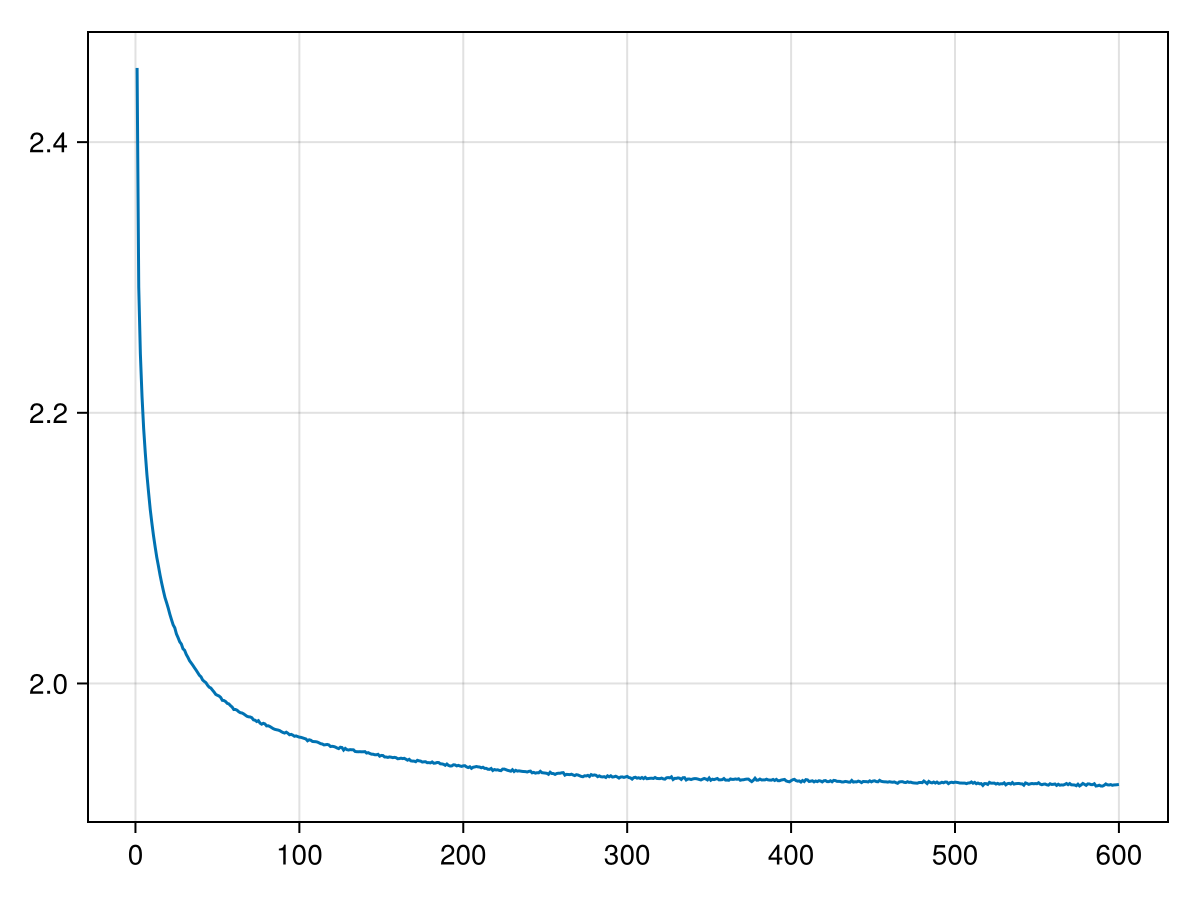

In [14]:
testmode!(model)
println("final crossentropy (training): ", Flux.crossentropy(model(Xtr),Ytr))
println("final crossentropy (dev): ",Flux.crossentropy(model(Xdev),Ydev))
lines(loss_history_average)

Let us now look at what kind of names we get.

In [15]:
function mpl_name_sample()
    out=Char[]
    slide=push!(collect(2:context_window_size),1)
    context=ones(Int32,context_window_size)
    while true
        p=reshape(model(context),:)
        distr=Distributions.Categorical(p);
        index=rand(distr)
        push!(out,index_to_char[index])
        if index==1
            break
        end
        context=context[slide]
        context[end]=index
    end
    return join(out)
end


mpl_name_sample (generic function with 1 method)

Let us generate a sample of 30000 names to compare the length statistics with that of the data. We also print 20 name examples.

In [19]:
generated_words=String[]
for i=1:30000
    push!(generated_words,mpl_name_sample())
end
generated_words[1:20] .|>println;

whia.
kastrey.
jessamynn.
nayheti.
zully.
saahik.
alemar.
chien.
naviyon.
seeir.
jucie.
kylen.
zcedun.
irtan.
anailah.
kalye.
jayline.
preslyn.
adelyna.
dmir.


length of the words list: 30000
mean length of a word: 7.073833333333333
standard deviation of length of a word: 1.4018966257754297


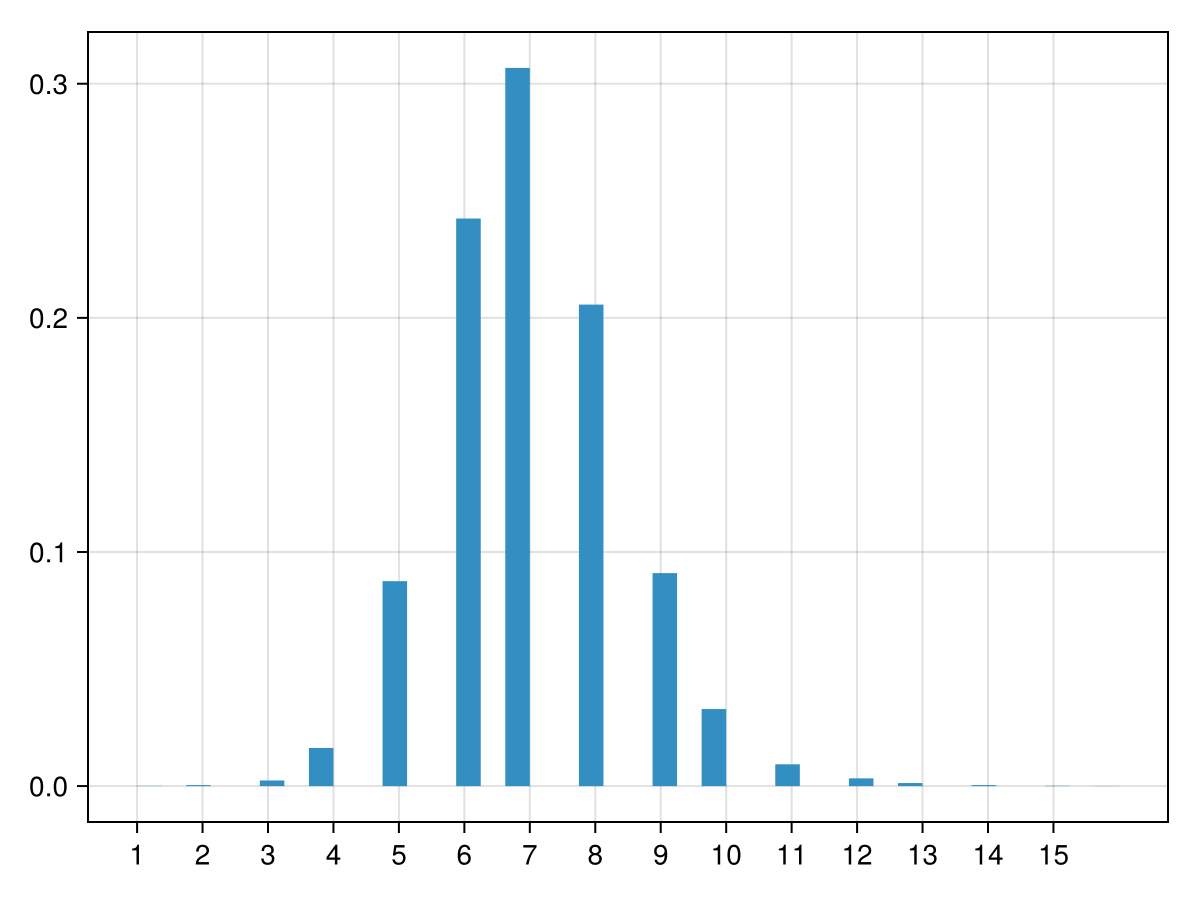

In [27]:
println("length of the words list: ",length(generated_words))
println("mean length of a word: ",mean(generated_words .|> length))
println("standard deviation of length of a word: ",sqrt(var(generated_words .|> length)))
fig=Figure()
ax=Axis(
    fig[1,1],
    xticks=1:15
)
hist!(ax,generated_words.|>length;bins=40,normalization=:probability)
fig

The result is a bit longer words but it looks quite good already!

In [28]:
using Serialization
serialize("mlp.model",model)